$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\Xvh}{\hat{\mathbf{X}}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Uv}{\mathbf{U}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\Zvh}{\hat{\mathbf{Z}}}
\newcommand{\Ev}{\mathbf{E}}
\newcommand{\onev}{\mathbf{1}}
\newcommand{\twov}{\mathbf{2}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

# Assignment 2

## Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas
import optimizers as opt
import time
import math

## Forward Propogation

$$ 
\begin{align*}
N &= \text{ number of samples } \\
I &= \text{ the number of attributes in each sample }\\
K &= \text{ number of units in output layer } \\
H_1 &= \text{ number of units in first hidden layer }\\
H_2 &= \text{ number of units in second hidden layer }\\
~\\
\Zv_1 &= \tanh(\Xvh\, \Uv) \\
\Zv_2 &= \tanh(\Zvh_1\, \Vv) \\
\Yv &= \Zvh_2\, \Wv\\
\end{align*}
$$

In [2]:
def network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=False):
    
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    n_W = (n_hiddens_2 + 1) * n_outputs
    
    U = w[:n_U].reshape((n_inputs + 1, n_hiddens_1))
    V = w[n_U: n_V + n_U].reshape((n_hiddens_1 + 1, n_hiddens_2))
    W = w[n_V + n_U:].reshape((n_hiddens_2 + 1, n_outputs))
    
    Z1 = np.tanh(np.insert(X, 0, 1, axis = 1) @ U)
    Z2 = np.tanh(np.insert(Z1,  0, 1, axis = 1) @ V)
    Y = np.insert(Z2, 0, 1, axis = 1) @ W
    
    return (Y, Z1, Z2) if all_outputs else Y

## Backward Propogation

$$
\begin{align*}
\nabla_\Yv E_{n,k} &= \frac{-2}{NK} (\Tv_{n,k} - \Yv_{n,k})\\
~\\
\nabla_\Wv E &= \nabla_\Yv E \nabla_\Wv \Yv\\
\delta_\Yv &= \frac{-2}{NK} (\Tv - \Yv)\\
\nabla_\Wv E &= \delta_\yv\Zvh_{\onev}\\
~\\
\nabla_\Vv E &= \nabla_\Yv E \nabla_\Zv{_\twov} Y \nabla_\Vv \Zv_\twov\\
\delta_\Zv{_\twov} &= \delta_\yv \Wv (\onev - {\Zv_\twov}^2)\\
\nabla_\Vv E &= \delta_\Zv{_\twov} \Zvh_\onev\\
~\\
\nabla_\Uv E &= \nabla_\Yv E \nabla_\Zv{_\twov} Y \nabla_\Zv{_\onev} \Zv_\twov \nabla_\Uv \Zv_{\onev}\\
\delta_\Zv{_\onev} &= \delta_\Zv{_\twov} \Vv (\onev - {\Zv_\onev}^2)\\
\nabla_\Uv E &= \delta_\Zv{_\onev} \Xvh\\
\end{align*}
$$

In [3]:
def error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    
    Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)
    n_samples = X.shape[0]
    Z1hat = np.insert(Z1, 0, 1, axis = 1)
    Z2hat = np.insert(Z2, 0, 1, axis = 1)
    Xhat = np.insert(X, 0, 1, axis = 1)
    n_U = (n_inputs + 1) * n_hiddens_1
    n_V = (n_hiddens_1 + 1) * n_hiddens_2
    n_W = (n_hiddens_2 + 1) * n_outputs
    
    delta_y = -2 * (T - Y) / (n_samples * n_outputs)
    dedw = Z2hat.T @ delta_y
    
    W = w[n_V + n_U:].reshape((n_hiddens_2 + 1, n_outputs))
    delta_z2 = (delta_y @ W[1:, :].T) * (1 - Z2 ** 2)
    dedv = Z1hat.T @ delta_z2
    
    V = w[n_U: n_V + n_U].reshape((n_hiddens_1 + 1, n_hiddens_2))
    #delta_z1 = (delta_z2 * (1 - Z1 ** 2)) @ V[1:, :]
    delta_z1 = (delta_z2 @ V[1:, :].T) * (1 - Z1 ** 2)
    dedu = Xhat.T @ delta_z1
    
    change_in_weights = np.hstack((dedu.flatten(), dedv.flatten(), dedw.flatten()))
    
    return change_in_weights

## Mean Square Error

In [4]:
def mse(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T):
    Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, False)
    return np.mean((T - Y)**2)

## Preparing Data

In [5]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data[['Time', 'CO(GT)']]
data = data [:23 * 20]  # first 20 days of data
data = data.dropna(axis=0)
print('data.shape =', data.shape)

hour = [int(t[:2]) for t in data['Time']]
X = np.array(hour).reshape(-1, 1)
CO = data['CO(GT)']
T = np.array(CO).reshape(-1, 1)
np.hstack((X, T))[:10]

data.shape = (443, 2)


array([[18. ,  2.6],
       [19. ,  2. ],
       [20. ,  2.2],
       [21. ,  2.2],
       [22. ,  1.6],
       [23. ,  1.2],
       [ 0. ,  1.2],
       [ 1. ,  1. ],
       [ 2. ,  0.9],
       [ 3. ,  0.6]])

## Standardizing Data

In [6]:
standardize = True

if standardize:
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0)
    
    X = (X - X_mean) / X_std

## Defining the hyperparameters

In [7]:
n_inputs = X.shape[1]
n_hiddens_1 = 5
n_hiddens_2 = 5
n_outputs = T.shape[1]

In [8]:
n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)

## Running Gradient Descent

In [9]:
n_iterations = 2000

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 1.150 and it took 1.16 seconds
Adam final error is 0.916 and it took 1.17 seconds
SCG final error is 0.911 and it took 2.27 seconds


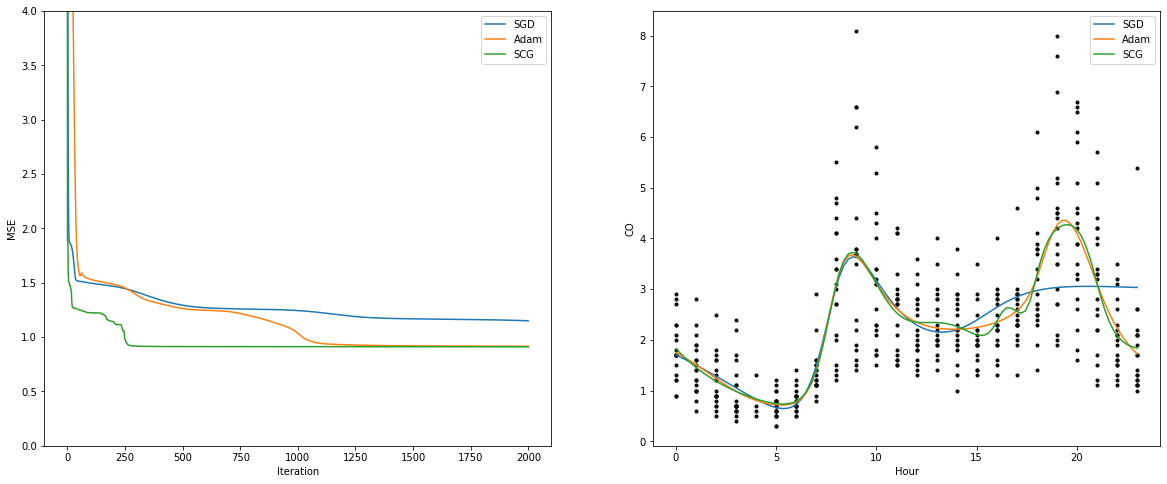

In [10]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(result_sgd['ftrace'], label='SGD')
plt.plot(result_adam['ftrace'], label='Adam')
plt.plot(result_scg['ftrace'], label='SCG')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.ylim(0, 4)

plt.subplot(1, 2, 2)
if standardize:
    plt.plot(X * X_std + X_mean, T, 'k.')  # unstandardize X
else:
    plt.plot(X, T, 'k.')
xs = np.linspace(0, 23, 100).reshape((-1, 1))
xs_standardized = (xs - X_mean) / X_std if standardize else xs
plt.plot(xs, network(result_sgd['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SGD')
plt.plot(xs, network(result_adam['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='Adam')
plt.plot(xs, network(result_scg['w'], n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, xs_standardized), label='SCG')
plt.legend()
plt.xlabel('Hour')
plt.ylabel('CO');

## Testing with multiple hyperparameters

In [11]:
results = []
for n_iterations in [10, 100, 1000]:
    for nh1 in [1, 2, 8, 10, 12]:
        for nh2 in [1, 2, 8, 10, 12]:
            
            n_U = (n_inputs + 1) * nh1
            n_V = (nh1 + 1) * nh2
            n_W = (nh2 + 1) * n_outputs
            initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)

            result_scg = opt.scg(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T], n_iterations = n_iterations)
            results.append([n_iterations, nh1, nh2, 0, 'scg', result_scg['ftrace'][-1]])
            
            for lr in [1e-1, 1e-3, 1e-5]:
                
                result_sgd = opt.sgd(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=lr, momentum_rate=0)
                result_adam = opt.adam(initial_w, mse, error_gradient, fargs=[n_inputs, nh1, nh2, n_outputs, X, T],
                                       n_iterations=n_iterations, learning_rate=lr)
                results.append([n_iterations, nh1, nh2, 'scg', result_scg['ftrace'][-1]])

                results.append([n_iterations, nh1, nh2, lr, 'sgd', result_sgd['ftrace'][-1]])
                results.append([n_iterations, nh1, nh2, lr, 'adam', result_adam['ftrace'][-1]])

results = pandas.DataFrame(results, columns=('Iterations', 'nh1', 'nh2', 'lr', 'algo', 'mse'))
results.sort_values(by = ['mse']).head(20)

,Iterations,nh1,nh2,lr,algo,mse
690,1000,10,12,0,scg,0.909827
683,1000,10,10,0.1,adam,0.909886
730,1000,12,10,0,scg,0.910317
680,1000,10,10,0,scg,0.910403
693,1000,10,12,0.1,adam,0.910878
640,1000,8,12,0,scg,0.910979
620,1000,8,8,0,scg,0.912040
630,1000,8,10,0,scg,0.912076
720,1000,12,8,0,scg,0.912127
670,1000,10,8,0,scg,0.912152


The best results are observerd when the number of iterations is maximum. SCG performed the best in my tests with ADAM in the second position. ADAM performs well when the learning rate is set to 0.1. A good value of MSE is obtained when the number of hidden units in each layer is between 8 - 12 but there are some exceptions. 

## Testing with different input and output units

In [12]:
X = np.arange(15).reshape((5, 3))
T = np.hstack((X[:, 0:1] * 0.1 * X[:, 1:2], X[:, 2:]**2)) # making two target values for each sample
T = T.reshape((5, 2))
print('  Input            Target')
for x, t in zip(X, T):
    print(x, '\t', t)

  Input            Target
[0 1 2] 	 [0. 4.]
[3 4 5] 	 [ 1.2 25. ]
[6 7 8] 	 [ 4.2 64. ]
[ 9 10 11] 	 [  9. 121.]
[12 13 14] 	 [ 15.6 196. ]


In [13]:
n_hiddens_1 = 50
n_hiddens_2 = 3
n_iterations = 1000


n_inputs = X.shape[1]
n_outputs = T.shape[1]

n_U = (n_inputs + 1) * n_hiddens_1
n_V = (n_hiddens_1 + 1) * n_hiddens_2
n_W = (n_hiddens_2 + 1) * n_outputs

initial_w = np.random.uniform(-0.1, 0.1, n_U + n_V + n_W)  # range of weights is -0.1 to 0.1

result_sgd = opt.sgd(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations, learning_rate=1e-1, momentum_rate=0.2, 
                     save_wtrace=True)
print(f'SGD final error is {result_sgd["ftrace"][-1]:.3f} and it took {result_sgd["time"]:.2f} seconds')

result_adam = opt.adam(initial_w, 
                       mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                       n_iterations=n_iterations, learning_rate=1e-2, 
                       save_wtrace=True)
print(f'Adam final error is {result_adam["ftrace"][-1]:.3f} and it took {result_adam["time"]:.2f} seconds')

result_scg = opt.scg(initial_w,
                     mse, error_gradient, fargs=[n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T],
                     n_iterations=n_iterations,
                     save_wtrace=True)
print(f'SCG final error is {result_scg["ftrace"][-1]:.3f} and it took {result_scg["time"]:.2f} seconds')

SGD final error is 2433.744 and it took 0.28 seconds
Adam final error is 3358.151 and it took 0.25 seconds
SCG final error is 178.329 and it took 0.39 seconds


In [14]:
result_scg['wtrace']

array([[-3.09064259e-02, -5.94114015e-02, -8.54876867e-02, ...,
         4.37264383e-02, -8.64941427e-02,  4.82359543e-02],
       [-3.09064259e-02, -5.94114015e-02, -8.54876867e-02, ...,
         4.37264383e-02, -8.64941427e-02,  4.82359543e-02],
       [-3.17387299e-02, -5.87195769e-02, -8.59605090e-02, ...,
         2.25825990e-01, -8.32733922e-02,  9.10846688e-02],
       ...,
       [-1.82479774e-01, -1.18926595e-01, -2.01002563e-01, ...,
         4.07178578e+01,  3.29352237e+00,  4.01692684e+01],
       [-1.82494406e-01, -1.18923815e-01, -2.00986733e-01, ...,
         4.07182088e+01,  3.29355669e+00,  4.01696193e+01],
       [-1.83232742e-01, -1.18783782e-01, -2.00218575e-01, ...,
         4.07376077e+01,  3.29545474e+00,  4.01890167e+01]])

In [15]:
w = result_scg['w']

Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)
Y.shape

(5, 2)

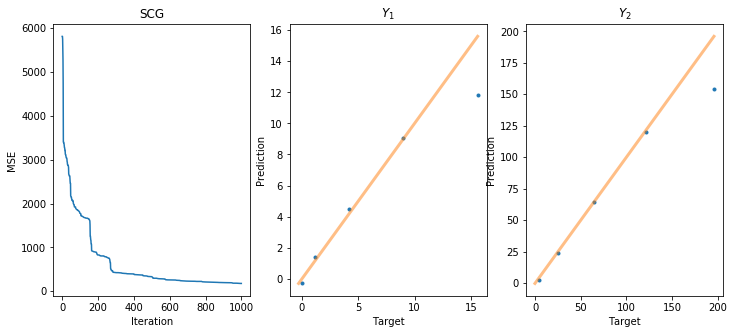

In [16]:
def plot_diagonal(T, Y):
    a = min(T.min(), Y.min())
    b = max(T.max(), Y.max())
    plt.plot([a, b], [a, b], '-', lw=3, alpha=0.5)

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(result_scg['ftrace'])
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('SCG')

plt.subplot(1, 3, 2)
plt.plot(T[:, 0], Y[:, 0], '.')
plot_diagonal(T[:, 0], Y[:, 0])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_1$')

plt.subplot(1, 3, 3)
plt.plot(T[:, 1], Y[:, 1], '.')
plot_diagonal(T[:, 1], Y[: 1])
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('$Y_2$');

In [17]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Kuvar-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
X = np.arange(3 * 4).reshape((3, 4)) * 0.1
T = np.hstack(( np.sin(X[:, 0:1]) + X[:, 1:2],
                X[:, 2:3] * -0.5,
                X[:, 3:4] ** 2))
n_inputs = X.shape[1]
n_outputs = T.shape[1]
n_hiddens_1 = 6
n_hiddens_2 = 2
n_w = (n_inputs + 1) * n_hiddens_1 + (n_hiddens_1 + 1) * n_hiddens_2 + (n_hiddens_2 + 1) * n_outputs
w = (np.arange(n_w) - n_w/2) * 0.01
Y = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X)


--- 20/20 points. Returned correct values.

Testing
Y, Z1, Z2 = network(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, all_outputs=True)


--- 20/20 points. Returned correct values.

Testing
grad = error_gradient(w, n_inputs, n_hiddens_1, n_hiddens_2, n_outputs, X, T)

grad [-0.01004135 -0.0140896  -0.018485